# multi-asset + strategy

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format='retina'

import vectorbt as vbt
import starfishX as sx
import starfishX.utilHelpers as ut
from tvDatafeed import TvDatafeed, Interval 

tv = TvDatafeed()

In [165]:
basket = ['aot','spali','intuch','rbf','jmart']
df = pd.DataFrame()
for i in basket:
  tmp = tv.get_hist(symbol=i,exchange='SET',
                            interval=Interval.in_daily,n_bars=5000)
  df[i] = tmp['close']
    
df.head(1),df.tail(1)

(                      aot  spali  intuch  rbf  jmart
 datetime                                            
 2004-04-07 09:00:00  5.55   5.45     NaN  NaN    NaN,
                        aot      spali  intuch   rbf      jmart
 datetime                                                      
 2023-04-20 09:00:00  72.25  22.799999    73.5  10.5  19.200001)

In [169]:
df = df.dropna()

In [170]:
# Define the target percentage allocation for each stock
target_percent = 0.2
init_cash=10000.0

# Calculate the target order size for each stock based on the initial cash and target percentage
order_size = (init_cash * target_percent) / df.iloc[0]
order_size = list(order_size.values)
order_size

[25.974025974025974,
 113.63636363636363,
 29.41176470588235,
 606.0606060606061,
 200.0]

In [171]:
price = df[df.index >= '2019-01-01']

fast_ma = vbt.MA.run(price, 10)
slow_ma = vbt.MA.run(price, 50)
entries = fast_ma.ma_crossed_above(slow_ma)
exits = fast_ma.ma_crossed_below(slow_ma)

# Define the target percentage allocation for each stock
target_percent = 0.2

# Define the portfolio value
portfolio_value = np.empty(df.shape)
portfolio_value[0] = init_cash

In [172]:
# Loop through each time step
for i in range(1, len(df)):
    # Calculate the current portfolio value
    portfolio_value[i] = portfolio_value[i - 1] + entries.iloc[i - 1] * df.iloc[i - 1].values

# Calculate the order sizes based on the current portfolio value and target percentage allocation
order_size = (portfolio_value * target_percent)  / df#.iloc[0].values

order_size

aot       spali     intuch         rbf       jmart
datetime                                                                     
2019-10-22 09:00:00  25.974026  113.636364  29.411765  606.060606  200.000000
2019-10-24 09:00:00  25.641026  112.994344  29.629630  458.715596  203.045685
2019-10-25 09:00:00  26.229508  117.647059  29.850746  495.049505  205.128205
2019-10-28 09:00:00  25.806452  118.343195  29.629630  444.444444  204.081633
2019-10-29 09:00:00  25.559105  122.699394  29.197080  460.829493  206.185567
...                        ...         ...        ...         ...         ...
2023-04-12 09:00:00  29.411034   91.246018  29.259060  185.951560   96.758014
2023-04-17 09:00:00  29.509278   90.445618  29.161204  184.261091   93.665297
2023-04-18 09:00:00  29.611034   90.050655  29.556610  179.369204   94.528567
2023-04-19 09:00:00  29.611034   90.844049  29.657143  182.601081  104.656633
2023-04-20 09:00:00  29.713495   90.445618  29.657143  193.035429  106.836974

[846 rows x 5 columns]

In [192]:
pf = vbt.Portfolio.from_signals(
    df,  # Price data for the assets
    entries, exits,
    init_cash=10000.0,  # Initial cash in the portfolio
    size_type=0,  # Use `SizeType.Value` for sizing
    size=order_size,  # Specify `size` for each asset
    cash_sharing=True  # Enable cash sharing among assets
)
# Print portfolio's position sizes
pf.entry_trades.records_readable

Entry Trade Id            Column        Size     Entry Timestamp  \
0                0     (10, 50, aot)   33.195021 2020-04-23 09:00:00   
1                1     (10, 50, aot)   35.299123 2020-09-02 09:00:00   
2                2     (10, 50, aot)   30.892366 2020-11-12 09:00:00   
3                3     (10, 50, aot)   32.198419 2021-02-16 09:00:00   
4                4     (10, 50, aot)   31.526154 2021-06-10 09:00:00   
5                5     (10, 50, aot)   32.348235 2021-08-30 09:00:00   
6                6     (10, 50, aot)   32.935714 2022-01-27 09:00:00   
7                7     (10, 50, aot)   28.402041 2022-10-28 09:00:00   
8                8     (10, 50, aot)   28.030000 2022-12-30 09:00:00   
9                9     (10, 50, aot)   28.136213 2023-01-26 09:00:00   
10              10     (10, 50, aot)   29.411034 2023-04-12 09:00:00   
11              11   (10, 50, spali)  121.951220 2020-04-15 09:00:00   
12              12   (10, 50, spali)  105.287078 2020-06-04 09:00:00   
13              13   (10, 50, spali)  115.982666 2020-11-11 09:00:00   
14              14   (10, 50, spali)   93.923364 2021-03-10 09:00:00   
15              15   (10, 50, spali)   95.461611 2021-06-08 09:00:00   
16              16   (10, 50, spali)   97.510140 2021-06-29 09:00:00   
17              17   (10, 50, spali)   94.957751 2021-07-22 09:00:00   
18              18   (10, 50, spali)   96.517143 2021-08-30 09:00:00   
19              19   (10, 50, spali)   89.081583 2021-10-25 09:00:00   
20              20   (10, 50, spali)   92.109502 2022-01-07 09:00:00   
21              21   (10, 50, spali)   89.869600 2022-01-27 09:00:00   
22              22   (10, 50, spali)   90.468142 2022-04-22 09:00:00   
23              23   (10, 50, spali)  103.489904 2022-08-08 09:00:00   
24              24   (10, 50, spali)   97.764762 2022-10-26 09:00:00   
25              25   (10, 50, spali)   83.969796 2023-02-08 09:00:00   
26              26  (10, 50, intuch)   34.334764 2020-01-29 09:00:00   
27              27  (10, 50, intuch)   24.283929 2020-04-28 09:00:00   
28              28  (10, 50, intuch)   37.622326 2020-11-06 09:00:00   
29              29  (10, 50, intuch)   35.355652 2021-03-29 09:00:00   
30              30  (10, 50, intuch)   28.006164 2021-08-11 09:00:00   
31              31  (10, 50, intuch)   26.146667 2021-11-25 09:00:00   
32              32  (10, 50, intuch)   27.033225 2021-12-24 09:00:00   
33              33  (10, 50, intuch)   26.711182 2022-02-17 09:00:00   
34              34  (10, 50, intuch)   27.171613 2022-03-14 09:00:00   
35              35  (10, 50, intuch)   29.983039 2022-07-19 09:00:00   
36              36  (10, 50, intuch)   29.971228 2022-11-10 09:00:00   
37              37  (10, 50, intuch)   28.472848 2023-02-22 09:00:00   
38              38  (10, 50, intuch)   28.864000 2023-03-28 09:00:00   
39              39     (10, 50, rbf)  442.477876 2020-01-31 09:00:00   
40              40     (10, 50, rbf)  471.911321 2020-04-20 09:00:00   
41              41     (10, 50, rbf)  196.250196 2020-09-28 09:00:00   
42              42     (10, 50, rbf)  190.837333 2021-01-25 09:00:00   
43              43     (10, 50, rbf)   97.373398 2021-06-22 09:00:00   
44              44     (10, 50, rbf)  102.031061 2021-09-20 09:00:00   
45              45     (10, 50, rbf)   98.723137 2021-10-28 09:00:00   
46              46     (10, 50, rbf)  118.707765 2022-04-27 09:00:00   
47              47     (10, 50, rbf)  143.363972 2022-08-25 09:00:00   
48              48     (10, 50, rbf)  154.523053 2022-11-21 09:00:00   
49              49   (10, 50, jmart)  222.222222 2020-01-23 09:00:00   
50              50   (10, 50, jmart)  263.394737 2020-04-23 09:00:00   
51              51   (10, 50, jmart)   55.264000 2021-07-23 09:00:00   
52              52   (10, 50, jmart)   53.975034 2021-08-30 09:00:00   
53              53   (10, 50, jmart)   36.360721 2022-03-24 09:00:00   
54              54   (10, 50, jmart)   34.39

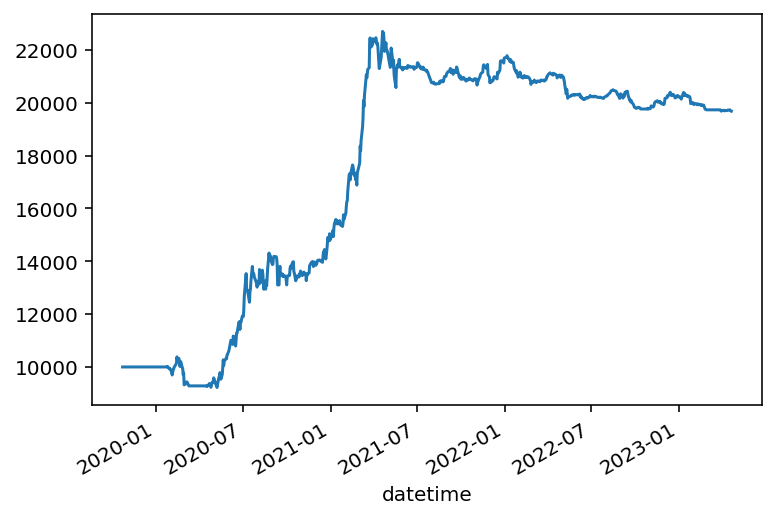

In [212]:
plt.subplots(facecolor='w')
(pf.asset_value()+pf.cash()).plot()
plt.show()

In [194]:
pf.asset_value()+pf.cash()

datetime
2019-10-22 09:00:00    10000.000000
2019-10-24 09:00:00    10000.000000
2019-10-25 09:00:00    10000.000000
2019-10-28 09:00:00    10000.000000
2019-10-29 09:00:00    10000.000000
                           ...     
2023-04-12 09:00:00    19719.827540
2023-04-17 09:00:00    19734.396299
2023-04-18 09:00:00    19698.179540
2023-04-19 09:00:00    19690.963540
2023-04-20 09:00:00    19683.610781
Name: group, Length: 846, dtype: float64

In [195]:
pf.total_profit()

9683.610781331317

In [218]:
pf.assets().tail(5)

ma_window                   10                         
ma_window                   50                         
                           aot spali  intuch  rbf jmart
datetime                                               
2023-04-12 09:00:00  29.411034   0.0  28.864  0.0   0.0
2023-04-17 09:00:00  29.411034   0.0  28.864  0.0   0.0
2023-04-18 09:00:00  29.411034   0.0  28.864  0.0   0.0
2023-04-19 09:00:00  29.411034   0.0  28.864  0.0   0.0
2023-04-20 09:00:00  29.411034   0.0  28.864  0.0   0.0

In [219]:
df.tail(5)

aot      spali  intuch   rbf      jmart
datetime                                                      
2023-04-12 09:00:00  72.50  22.600000   74.50  10.9  21.200001
2023-04-17 09:00:00  72.75  22.799999   74.75  11.0  21.900000
2023-04-18 09:00:00  72.50  22.900000   73.75  11.3  21.700001
2023-04-19 09:00:00  72.50  22.700001   73.50  11.1  19.600000
2023-04-20 09:00:00  72.25  22.799999   73.50  10.5  19.200001

In [222]:
73.50*28.864 + 72.25*29.411034

4246.4512065

In [223]:
pf.asset_value().tail(5)

datetime
2023-04-12 09:00:00    4282.668000
2023-04-17 09:00:00    4297.236759
2023-04-18 09:00:00    4261.020000
2023-04-19 09:00:00    4253.804000
2023-04-20 09:00:00    4246.451241
Name: group, dtype: float64

In [198]:
pf.entry_trades.records_readable.groupby('Column')['PnL'].sum()

Column
(10, 50, aot)       -252.238505
(10, 50, intuch)    -135.218832
(10, 50, jmart)     7912.874611
(10, 50, rbf)       2542.523296
(10, 50, spali)     -384.329789
Name: PnL, dtype: float64

<AxesSubplot:xlabel='datetime'>

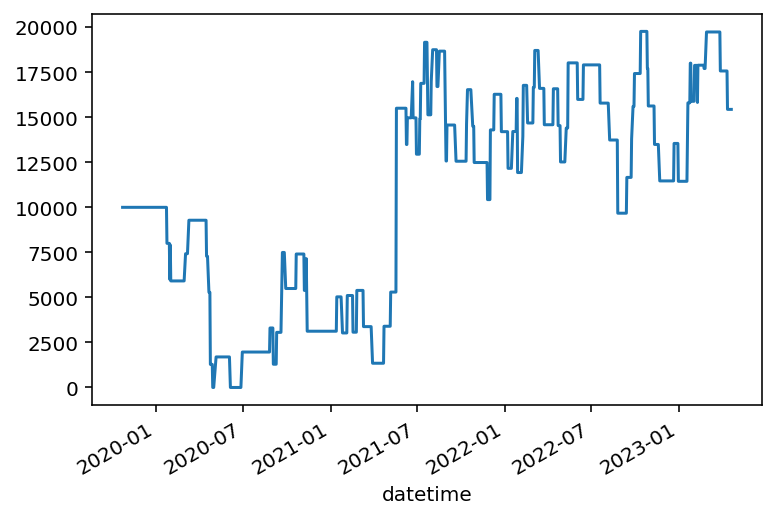

In [215]:
plt.subplots(facecolor='w')
pf.cash().plot()

<AxesSubplot:xlabel='datetime'>

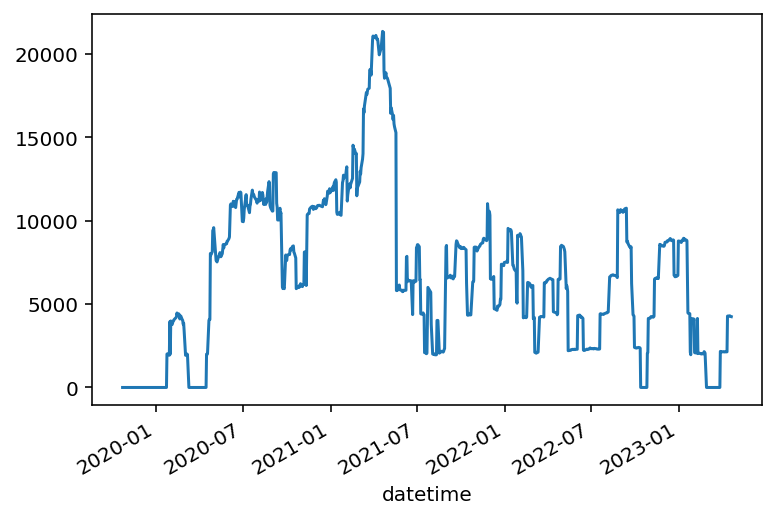

In [213]:
plt.subplots(facecolor='w')
pf.asset_value().plot()